In [1]:
import torch
import pdb
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")

In [2]:
# Prints the package versions for reproducibility
!pip list | grep "torch\>\|matplotlib[^-]\|numpy\|ipywidgets"

ipywidgets                       7.7.1
matplotlib                       3.7.1
numpy                            1.23.5
torch                            2.1.0+cu121


## [Gradients for non-differentiable functions](https://pytorch.org/docs/stable/notes/autograd.html#gradients-for-non-differentiable-functions)

### Convex Functions

> 2. If the function is convex (at least locally),
> use the sub-gradient of minimum norm
> (it is the steepest descent direction).

#### Rmk (Warning: This remark can be a bit **mathy**)

Since $\mathbb{R}^n$ is finite dimensional, all norms on $\mathbb{R}^n$ are equivalent. We can therefore
interpret the above norm as the Euclidean norm and rest
assured that the sub-gradient $g$ of minimum Euclidean norm
is **also minimum in terms of all the other norms**.

##### Proof of Minimality among Equiv Norms

Indeed, let $\|\cdot\|$ and $\|\cdot\|'$ be
two equivalent norms on $\mathbb{R}^n$ and let
$g \in \mathbb{R}^n$ be s.t. $\|g\| \le \|x\| \quad\forall\; x \in \mathbb{R}^n$, i.e. $g$
is of minimal norm in terms of $\|\cdot\|$. We now
prove the minimality of $\|g\|'$. Let $z \in \mathbb{R}^n$
be arbitrary. By definition of equivalence of norms, we have

$$ \exists\; a, b > 0 \quad \text{s.t.} \quad a\|y\| \le \|y\|' \le b\|y\| \quad \forall\; y \in \mathbb{R}^n.
$$

With these, we see that

$$ \|g\|' \le b\|g\| \le b\|\frac{a}{b}z\|
\le a\|z\| \le \|z\|'.
$$

##### In Particular

A vector $g \in \mathbb{R}^n$, when
viewed as a linear transformation

$$\begin{align}
L_{g} &\in \mathcal{L}(\mathbb{R}^n, \mathbb{R}), \\
L_{g}(x) &:= g^{T} x \quad\forall\; x \in \mathbb{R}^n,\end{align}$$

enjoys the same norm. That is,

$$\|L_{g}\| = \|g\|.$$

Indeed,

$$\|L_{g}\| = \sup_{\|x\|=1} L_{g}(x)
= \sup_{\theta} \|g\| \cos\theta
= \|g\|.
$$

#### Examples
As examples of convex functions, let's inspect in PyTorch
- The ReLU function $\text{ReLU}(x) := \max (x, 0)$
- The absolute value function $\left| \,\cdot\, \right|: \mathbb{R} \to \mathbb{R}$

These two functions both have a non-differentiable point at 0.

In [3]:
def viz_f_prime_at(
    f,
    at,
    *args,
    alpha=0.3,
    xrange=5,
    print_grad=True,
):
    if not hasattr(f, "__name__"):
        f.__name__ = repr(f)

    x = torch.tensor(float(at), requires_grad=True)
    y = f(x)
    y.backward()
    if print_grad:
        print(f'{f.__name__}\'({at}) = {x.grad}')
        print()

    f_color = "cyan"
    plt.plot(at, y.item(), marker="o", color=f_color)

    left_endpoint = at - xrange
    right_endpoint = at + xrange
    x_ = torch.linspace(left_endpoint, right_endpoint, steps=100)
    y_ = f(x_)
    # Color name: https://matplotlib.org/stable/gallery/color/named_colors.html
    plt.plot(x_, y_,
             alpha=alpha,
             label=f'y = {f.__name__}(x)',
             color=f_color,
    )


    slope = x.grad.item()
    xx = np.array([left_endpoint, right_endpoint])
    yy = (xx - at) * slope + y.item()
    plt.plot(xx, yy,
             "--",
             alpha=alpha,
             label=f'y = ({f.__name__}\'({at})={slope:.2f})*x',
             color="chartreuse",
    )
    plt.legend()
    ytop = y.item() + xrange
    ybottom = y.item() - xrange
    plt.ylim([ybottom, ytop])

    # x,y-axis
    # plt.hlines(y=0, xmin=left_endpoint, xmax=right_endpoint,
    #            alpha=alpha,
    # )
    # plt.vlines(x=0, ymin=ybottom, ymax=ytop,
    #            colors="w",
    #            alpha=alpha,
    # )

cos'(2.7) = -0.427379846572876



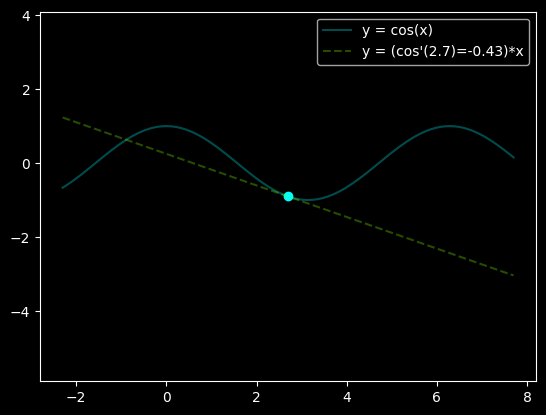

In [4]:
# Unit test
viz_f_prime_at(torch.cos, 2.7)

##### `torch.relu` or `torch.nn.ReLU`

relu'(0) = 0.0



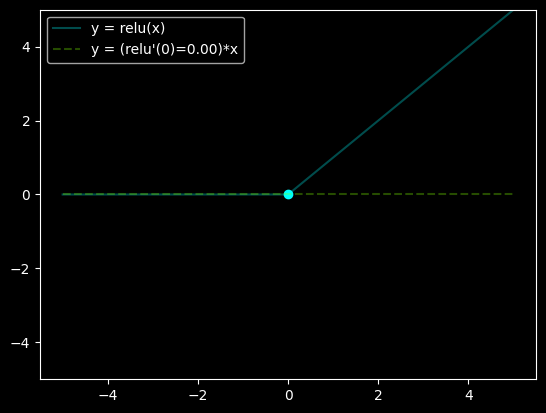

In [5]:
viz_f_prime_at(torch.relu, 0)

ReLU()'(0) = 0.0



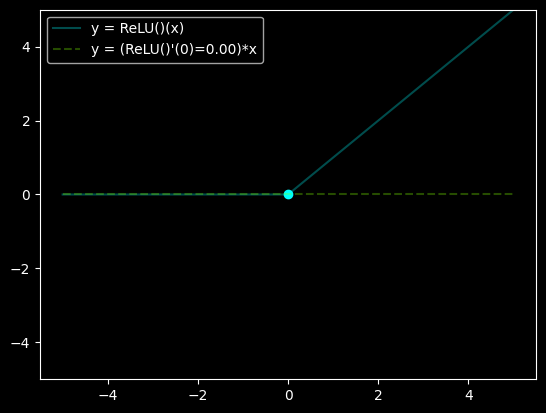

In [6]:
viz_f_prime_at(torch.nn.ReLU(), 0)

##### `torch.abs`

abs'(0) = 0.0



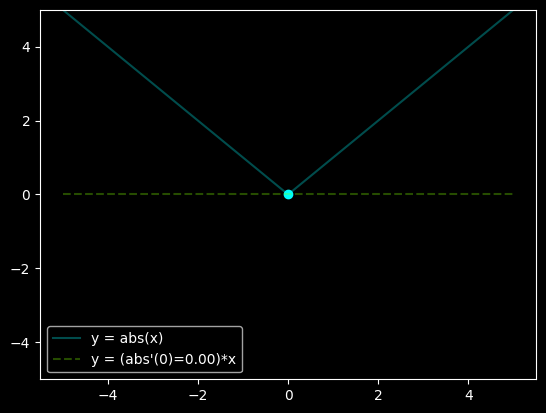

In [7]:
viz_f_prime_at(torch.abs, 0)

So, indeed as indicated in the Autograd Mechanics article, in these two examples the sub-gradients are both chosen to be the one of minimum norm.

### Concave Functions

> 3. If the function is concave (at least locally),
> use the super-gradient of minimum norm
> (consider -f(x) and apply the previous point).

The **easiest concave function** from $\mathbb{R}$ to $\mathbb{R}$ is probably a **piecewise linear function** (like ReLU but folding into the opposite side).

We'll be using leaky ReLU.

In [8]:
def viz_leaky_relu_prime_at_0(
    left_slope,
    *args,
    alpha=0.3, left_endpoint=-5, right_endpoint=5,
    print_grad=True,
):
    leaky_relu = torch.nn.LeakyReLU(left_slope)
    x = torch.tensor(0., requires_grad=True)
    y = leaky_relu(x)
    y.backward()
    plt.plot(x.item(), y.item(),
             marker="o",
            #  alpha=alpha,
             color="cyan",
    )
    if print_grad:
        print(f'{x.grad = }')
        print(f'{torch.eq(x.grad, torch.tensor(left_slope)) = }')
        print()

    x_ = torch.linspace(left_endpoint, right_endpoint, steps=100)
    y_ = leaky_relu(x_)
    # Color name: https://matplotlib.org/stable/gallery/color/named_colors.html
    plt.plot(x_, y_,
             alpha=alpha,
             label="y = leaky_relu(x)",
             color="cyan",
    )
    slope = x.grad.item()
    xx = np.array([left_endpoint, right_endpoint])
    yy = xx * slope
    plt.plot(xx, yy,
             "--",
             alpha=alpha,
             label=f'y = (x.grad={slope:.2f})*x',
             color="chartreuse",
    )
    plt.legend()
    ytop = 2*max(left_endpoint, right_endpoint)
    ybottom = -ytop
    plt.ylim([ybottom, ytop])
    # W/o plt.show() the plots will get cluttered
    plt.show()

In [ ]:
# viz_leaky_relu_prime_at_0(0.01)

In [9]:
from ipywidgets import interact, FloatSlider

left_slope_slider = FloatSlider(
    value=0.1, min=-10, max=10, step=0.1,
)

In [10]:
@interact(left_slope=left_slope_slider)
def interactive_viz_leaky_relu_prime_at_0(left_slope):
    viz_leaky_relu_prime_at_0(left_slope)

interactive(children=(FloatSlider(value=0.1, description='left_slope', max=10.0, min=-10.0), Output()), _dom_c…

In [ ]:
# interact(viz_leaky_relu_prime_at_0, left_slope=left_slope_slider);

So, empirically, we see that `leaky_relu'(0) = left_slope` for PyTorch's `torch.nn.LeakyReLU`.

The same is observed in Zygote.jl (a Julia autodiff package) if we define Leaky ReLU in Julia as
```julia
x -> max(x, 0) + left_slope * min(x, 0)
```

Indeed, as the following Julia REPL session (`julia version 1.8.3`, `Zygote v0.6.67`) shows.
```julia
julia> using Zygote

julia> gradient(x -> max(x, 0) + 2min(x, 0), 0)
(2.0,)

julia> gradient(x -> max(x, 0) + 1.1min(x, 0), 0)
(1.1,)

julia> gradient(x -> max(x, 0) + 0.9min(x, 0), 0)
(0.9,)

julia> gradient(x -> max(x, 0) + -0.9min(x, 0), 0)
(-0.9,)
```

leaky ReLU is concave $\iff \texttt{left_slope} \ge 1$.

In this case, the super-differential of Leaky ReLU at $0$,
i.e. the set of all super-gradients,
equals the interval $[1, \texttt{left_slope}]$.

The super-gradient of minimum norm among $[1, \texttt{left_slope}]$ is therefore $1$. In other words,
the above experiment on the concave
leaky ReLU **contradicts** what was said in the Autograd Mechanics article.

### The Rest

> 4. If the function is defined, define the gradient
> at the current point by continuity
> (note that `inf` is possible here, for example
> for `sqrt(0)`). If multiple values are possible,
> pick one arbitrarily.

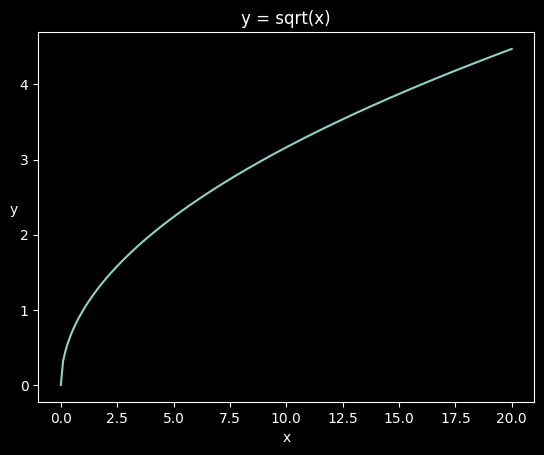

In [11]:
x = torch.linspace(0, 20, 200)
y = torch.sqrt(x)
plt.plot(x, y,
         #label="$y = \sqrt{x}$",
)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
# plt.legend();
plt.title("y = sqrt(x)");

In [12]:
x = torch.tensor(0., requires_grad=True)
y = torch.sqrt(x)
y.backward()
print(f'{x.grad = }')

x.grad = tensor(inf)


In [13]:
x = torch.tensor(-0., requires_grad=True)
y = torch.sqrt(x)
y.backward()
print(f'{x.grad = }')

x.grad = tensor(-inf)


In [14]:
x = torch.tensor(-1e-20, requires_grad=True)
y = torch.sqrt(x)
y.backward()
print(f'{x.grad = }')

x.grad = tensor(nan)


In [15]:
x = torch.tensor(0., requires_grad=True)
y = torch.sqrt(-x)
y.backward()
print(f'{x.grad = }')

x.grad = tensor(inf)


> 5. If the function is not defined
> (`sqrt(-1)`, `log(-1)` or most functions when
> the input is `NaN`, for example) then the value
> used as the gradient is arbitrary (we might also
> raise an error but that is not guaranteed).
> Most functions will use `NaN` as the gradient,
> but for performance reasons, some functions will
> use other values (`log(-1)`, for example).

"Performance reasons"... 🤔 Curious.

In [16]:
torch.sqrt(torch.tensor(-1))

tensor(nan)

In [17]:
torch.sqrt(torch.tensor(-1.))

tensor(nan)

In [18]:
torch.sqrt(torch.tensor([-1]))

tensor([nan])

In [19]:
x = torch.tensor(-1., requires_grad=True)
y = torch.sqrt(x)
y.backward()
print(f'{x.grad = }')

x.grad = tensor(nan)


In [20]:
torch.log(torch.tensor(-1))

tensor(nan)

In [21]:
x = torch.tensor(-1., requires_grad=True)
y = torch.log(x)
y.backward()
print(f'{x.grad = }')

x.grad = tensor(-1.)


## Input Args of The `backward` Method

Signature
```python
y.backward(
    gradient=None,
    retain_graph=None,
    create_graph=False,
    inputs=None,
)
```

- `gradient`: This is like the `grad` in `tools/autograd/derivatives.yaml`, representing the gradient from previous derivation steps.
    - For **scalar** tensors, we **do not need to specify** `gradient` because it's assumed to be `1.0`.
    - For **vector/general** tensors, the specification of `gradient` is **mandatory**.
- `retain_graph`
- `create_graph`
- `inputs`

In [ ]:
x = torch.rand(1, 4, requires_grad=True)
y = x**2
objective = torch.sum(y)
print(f'{x = }')
print(f'{y = }')
print(f'{objective = }')

In [ ]:
gradient = torch.zeros_like(x)
c = 1.0
gradient[0, 0] = c
print(f'{gradient = }')

x.grad = None
y.backward(gradient, retain_graph=True)
print(f'{x.grad = }')
with torch.no_grad():
    print(f'{2*c*x  = }')

In [ ]:
gradient = torch.zeros_like(x)
c = 2.0
gradient[0, -1] = c
print(f'{gradient = }')

x.grad = None
y.backward(gradient, retain_graph=True)
print(f'{x.grad = }')
with torch.no_grad():
    print(f'{2*c*x  = }')

In [ ]:
gradient = torch.ones_like(x)
print(f'{gradient = }')

x.grad = None
y.backward(gradient, retain_graph=True)
print(f'{x.grad = }')
with torch.no_grad():
    print(f'{2*x    = }')

In [ ]:
gradient = torch.rand([])

x.grad = None
objective.backward(gradient, retain_graph=True)
print(f'{"x.grad":15s} = {x.grad}')
with torch.no_grad():
   print(f'{"gradient*2*x":15s} = {gradient*2*x}')